In [44]:
pip install utils

Note: you may need to restart the kernel to use updated packages.


In [47]:
pip install livelossplot

Note: you may need to restart the kernel to use updated packages.


In [50]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings, random, cv2
warnings.filterwarnings('ignore')
import tensorflow as tf
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.preprocessing.image import load_img
from keras.layers import Conv2D, Flatten, Dropout, Dense, MaxPooling2D, BatchNormalization
print("Tensorflow version:", tf.__version__)


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras
import tensorflow as tf

Tensorflow version: 2.6.4


In [13]:
train_dir = "../input/facial-expression-dataset/train/train/"
test_dir = "../input/facial-expression-dataset/test/test/"

In [6]:
for expression in os.listdir("../input/facial-expression-dataset/train/train"):
    print(str(len(os.listdir("../input/facial-expression-dataset/train/train/" + expression))) + " " + expression + " images")

3171 surprise images
4097 fear images
3995 angry images
4965 neutral images
4830 sad images
436 disgust images
7215 happy images


In [14]:
def import_images(directory):
    image_paths = []
    labels = []
    
    for category in os.listdir(directory):
        for filename in os.listdir(directory+category):
            image_path = os.path.join(directory,category,filename)
            image_paths.append(image_path)
            labels.append(category)
        
    return image_paths, labels

In [17]:
train = pd.DataFrame()
train['image'], train['label'] = import_images(train_dir)
train = train.sample(frac=1).reset_index(drop=True)
train.head()

,image,label
0,../input/facial-expression-dataset/train/train...,angry
1,../input/facial-expression-dataset/train/train...,sad
2,../input/facial-expression-dataset/train/train...,neutral
3,../input/facial-expression-dataset/train/train...,surprise
4,../input/facial-expression-dataset/train/train...,neutral


In [18]:
test = pd.DataFrame()
test['image'], test['label'] = import_images(test_dir)
test.head()

,image,label
0,../input/facial-expression-dataset/test/test/s...,surprise
1,../input/facial-expression-dataset/test/test/s...,surprise
2,../input/facial-expression-dataset/test/test/s...,surprise
3,../input/facial-expression-dataset/test/test/s...,surprise
4,../input/facial-expression-dataset/test/test/s...,surprise


**Exploratory Data Analysis**

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

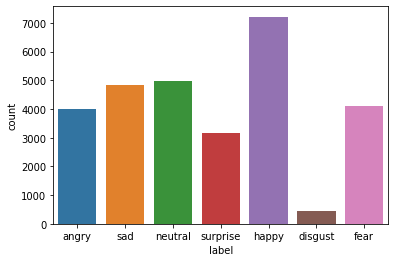

In [19]:
sns.countplot(train.label)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

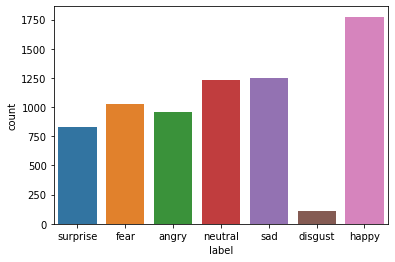

In [20]:
sns.countplot(test.label)

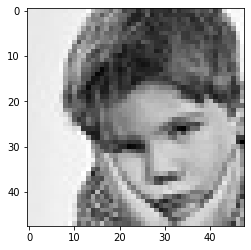

In [23]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img,cmap='gray');

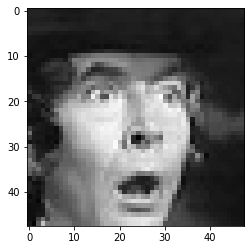

In [24]:
img = Image.open(test['image'][0])
plt.imshow(img, cmap='gray')

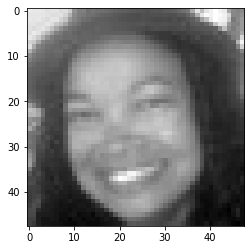

In [25]:
img = Image.open(train['image'][232])
plt.imshow(img,cmap='gray');

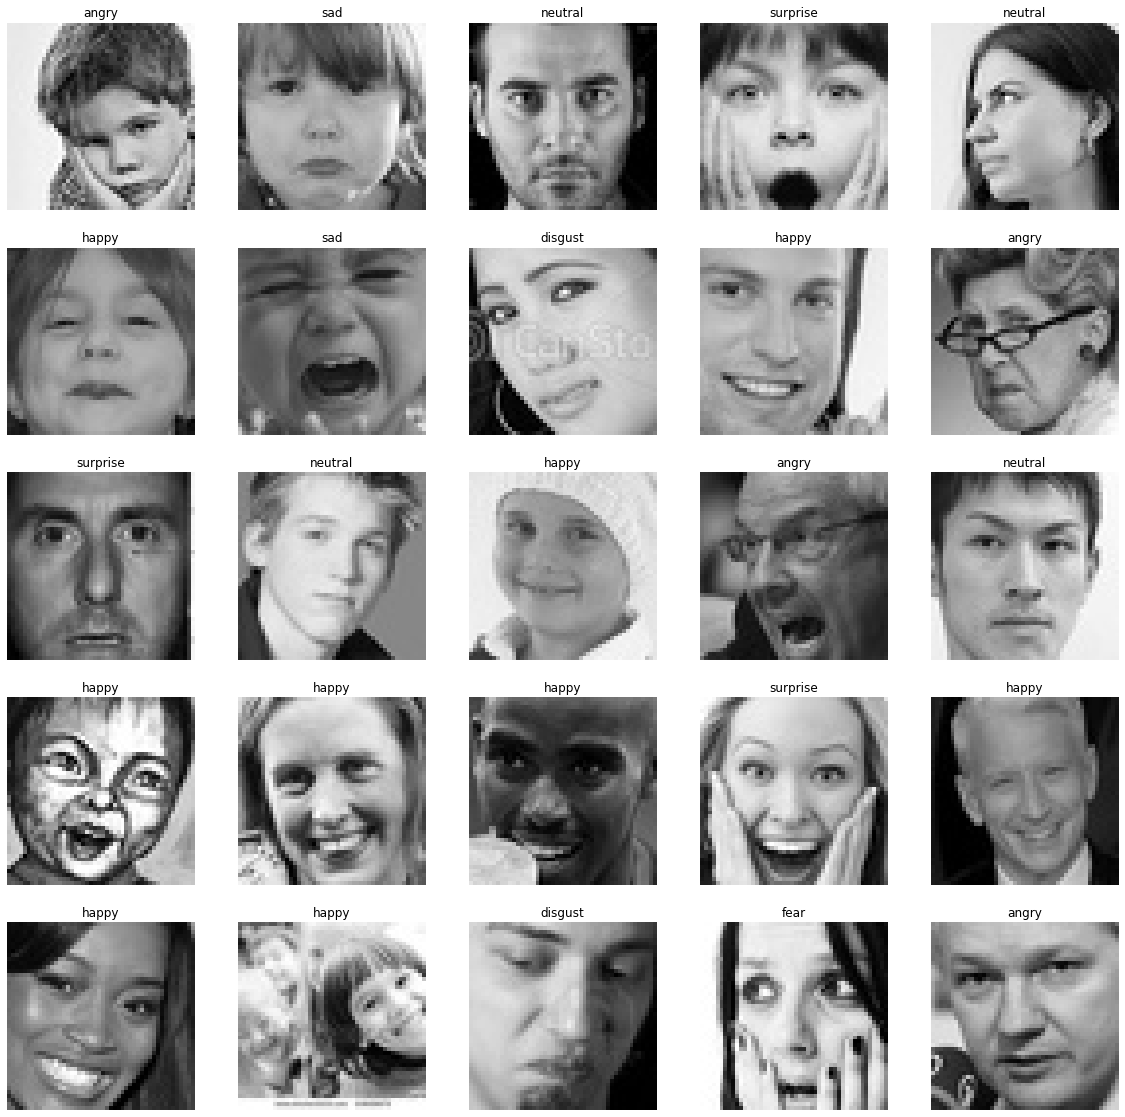

In [29]:
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for idx, file, label in files.itertuples():
    plt.subplot(5,5,idx+1)
    image = load_img(file)
    image = np.array(image)
    plt.imshow(image,cmap='gray')
    plt.title(label)
    plt.axis('off')

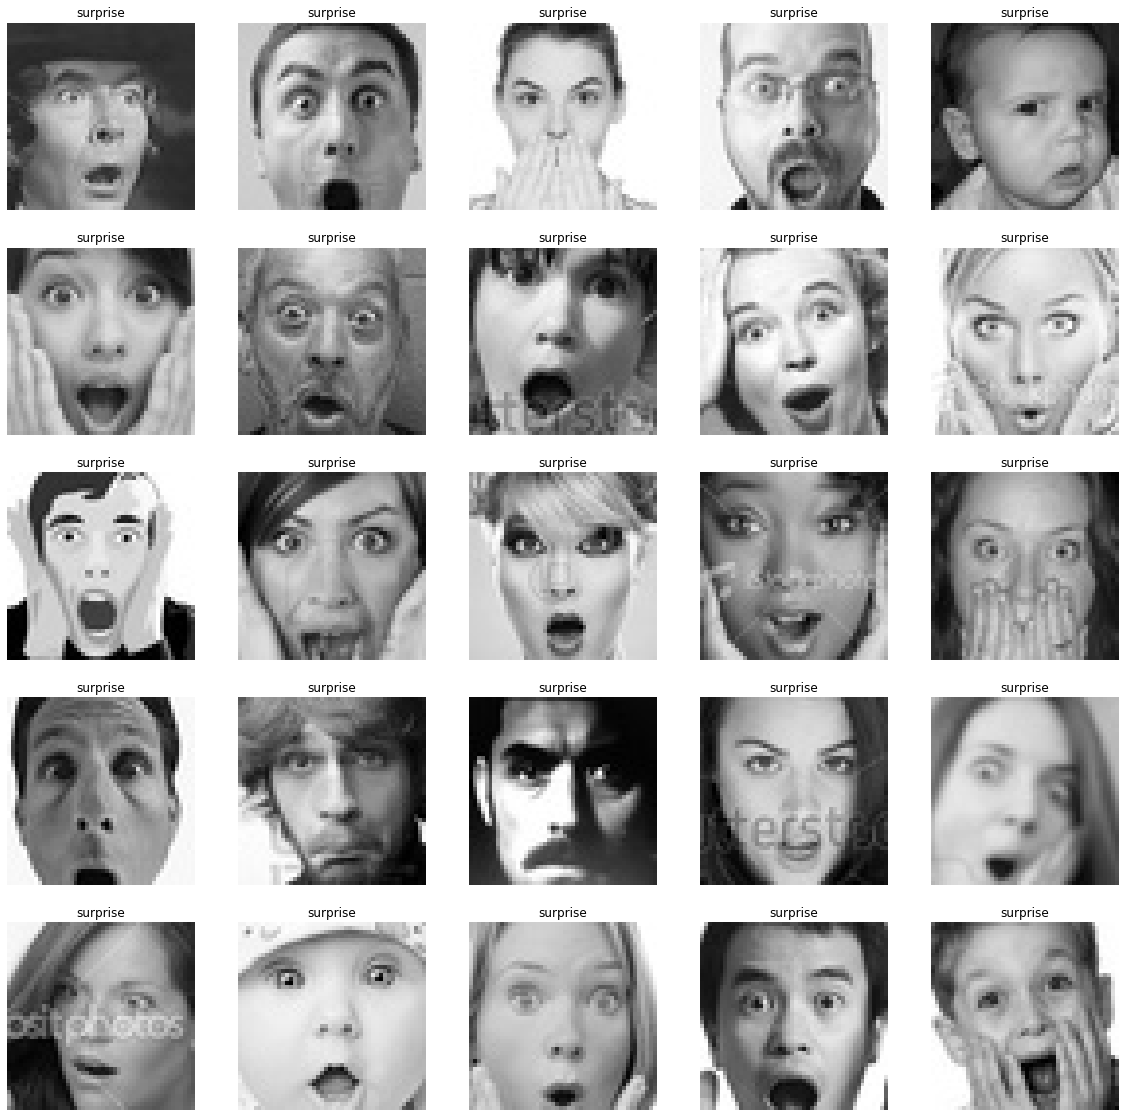

In [30]:
plt.figure(figsize=(20,20))
files = test.iloc[0:25]

for idx, file, label in files.itertuples():
    plt.subplot(5,5,idx+1)
    image = load_img(file)
    image = np.array(image)
    plt.imshow(image,cmap='gray')
    plt.title(label)
    plt.axis('off')

In [31]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator(horizontal_flip=True)


train_generator = datagen_train.flow_from_directory(train_dir,
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)
datagen_validation = ImageDataGenerator(horizontal_flip=True)



validation_generator = datagen_validation.flow_from_directory(test_dir,
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [33]:
# Initialising the CNN
model = Sequential()
# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# Flattening
model.add(Flatten())
# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(7, activation='softmax'))
opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_6 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_6 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_7 (Batch (None, 24, 24, 128)      

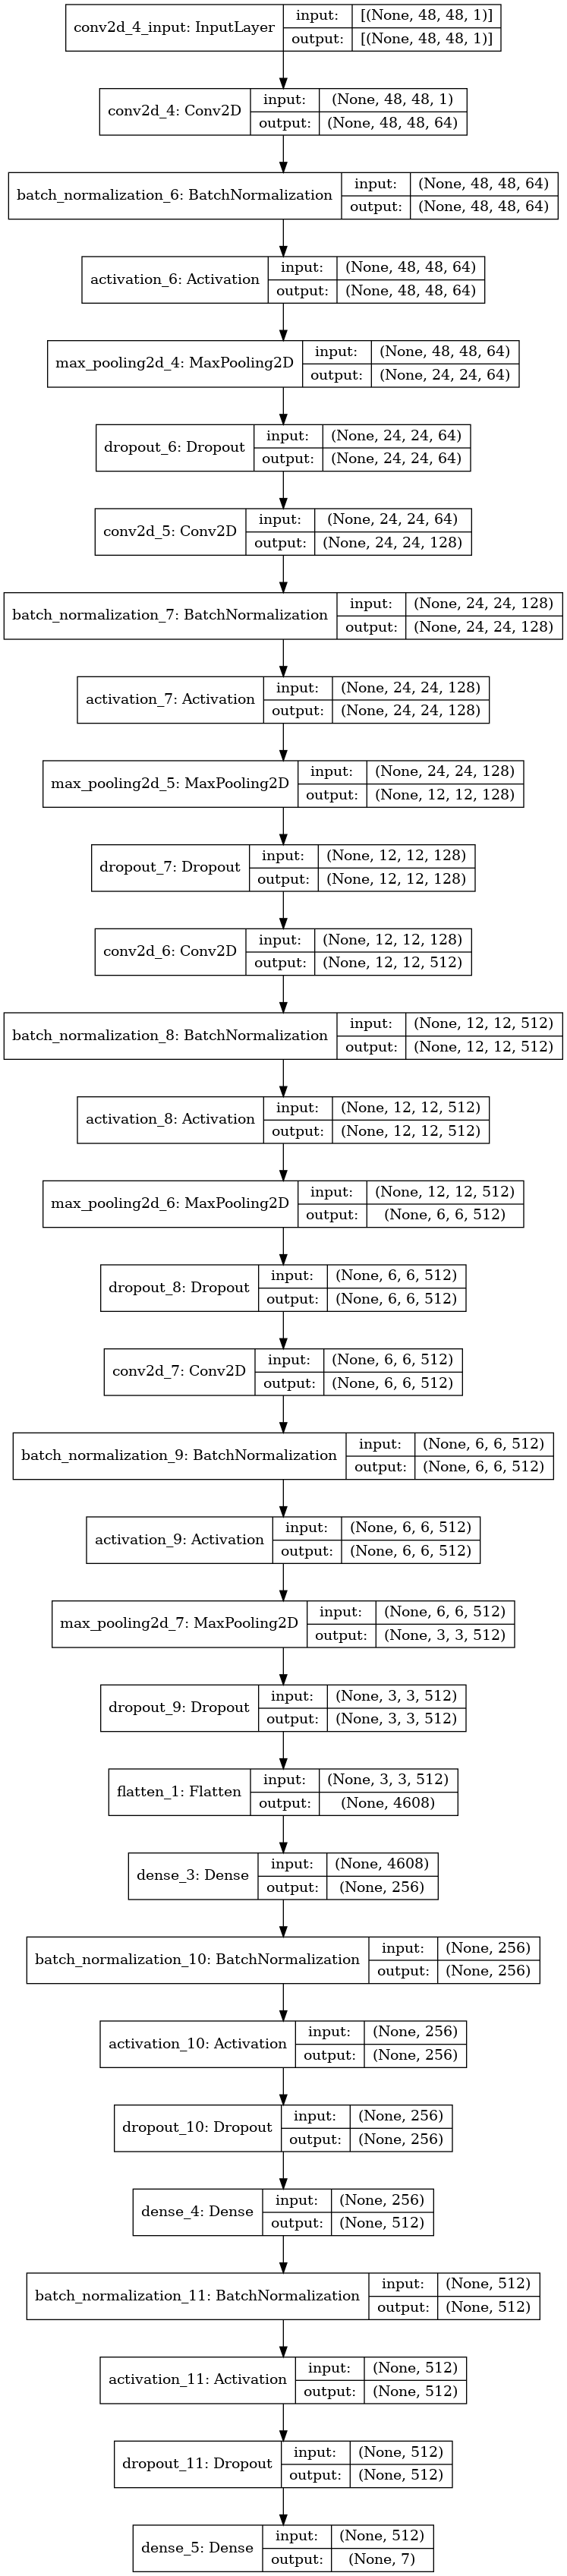

In [35]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image('model.png',width=400, height=200)

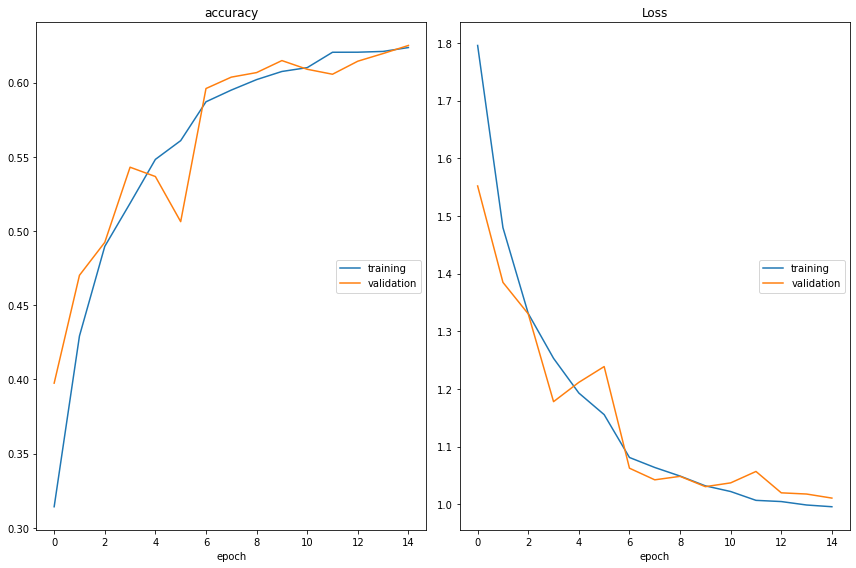

accuracy
	training         	 (min:    0.314, max:    0.624, cur:    0.624)
	validation       	 (min:    0.397, max:    0.625, cur:    0.625)
Loss
	training         	 (min:    0.996, max:    1.796, cur:    0.996)
	validation       	 (min:    1.010, max:    1.552, cur:    1.010)

Epoch 00015: saving model to model_weights.h5
CPU times: user 7h 58min 20s, sys: 2min 44s, total: 8h 1min 4s
Wall time: 2h 16min 41s


In [51]:
%%time
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKeras(), checkpoint, reduce_lr]
history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

In [52]:
model_json = model.to_json()
model.save_weights('model_weights.h5')
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [53]:
from tensorflow.keras.models import model_from_json
class FacialExpressionModel(object):
    EMOTIONS_LIST = ["Angry", "Disgust",
                    "Fear", "Happy",
                    "Neutral", "Sad",
                    "Surprise"]
    def __init__(self, model_json_file, model_weights_file):
        # load model from JSON file
        with open(model_json_file, "r") as json_file:
            loaded_model_json = json_file.read()
            self.loaded_model = model_from_json(loaded_model_json)
        # load weights into the new model
        self.loaded_model.load_weights(model_weights_file)
        self.loaded_model.make_predict_function()
    def predict_emotion(self, img):
        self.preds = self.loaded_model.predict(img)
        return FacialExpressionModel.EMOTIONS_LIST[np.argmax(self.preds)]

In [54]:
import cv2
facec = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
model = FacialExpressionModel("model.json", "model_weights.h5")
font = cv2.FONT_HERSHEY_SIMPLEX
class VideoCamera(object):
    def __init__(self):
        self.video = cv2.VideoCapture(0)
    def __del__(self):
        self.video.release()
    # returns camera frames along with bounding boxes and predictions
    def get_frame(self):
        _, fr = self.video.read()
        gray_fr = cv2.cvtColor(fr, cv2.COLOR_BGR2GRAY)
        faces = facec.detectMultiScale(gray_fr, 1.3, 5)
        for (x, y, w, h) in faces:
            fc = gray_fr[y:y+h, x:x+w]
            roi = cv2.resize(fc, (48, 48))
            pred = model.predict_emotion(roi[np.newaxis, :, :, np.newaxis])
            cv2.putText(fr, pred, (x, y), font, 1, (255, 255, 0), 2)
            cv2.rectangle(fr,(x,y),(x+w,y+h),(255,0,0),2)
        return fr

In [55]:
def gen(camera):
    while True:
        frame = camera.get_frame()
        cv2.imshow('Facial Expression Recognization',frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()

In [ ]:
gen(VideoCamera())